In [1]:
#========================================================================
# Copyright 2019 Science Technology Facilities Council
# Copyright 2019 University of Manchester
#
# This work is part of the Core Imaging Library developed by Science Technology	
# Facilities Council and University of Manchester
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0.txt
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# 
#=========================================================================

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

In [3]:
# imports
from ccpi.framework import ImageData, ImageGeometry
from ccpi.framework import AcquisitionData, AcquisitionGeometry
from ccpi.astra.operators import AstraProjectorSimple 

import numpy as np
import matplotlib.pyplot as plt

# define some utilities

# simulate 'ideal', i.e. noise-free, sino
def get_ideal_sino(data, N, n_angles):
    
    # get ImageGeometry
    ig = data.geometry

    # Create AcquisitionGeometry
    angles = np.linspace(0, np.pi, n_angles, dtype=np.float32)

    ag = AcquisitionGeometry(geom_type = 'parallel',
                             dimension = '2D', 
                             angles = angles,
                             pixel_num_h = N)

    dev = 'cpu'

    Aop = AstraProjectorSimple(ig, ag, dev)    
    sino = Aop.direct(data)
    return sino.as_array()

# simulate noisy projetion, flat and adrk field images
def get_real_sino(data, N, n_angles, n_bit):
    
    # detector bit depth
    n_levels = 2 ** n_bit - 1
    I_0 = 0.9 * n_levels
    
    # center of rotation offset
    cor_offset = 0
    
    # shift senter of rotation
    sino = np.roll(get_ideal_sino(data, N, n_angles), cor_offset, axis = 1)
    
    # generate flat field image (i.e. imitate non-uniform pixel response)
    flat = np.uint32(np.tile(np.round(I_0 - I_0 * 0.1 * np.random.rand(1, N)), (n_angles, 1)))
    
    # generate dark field image (i.e. imitate dark current)
    dark = np.uint32(np.tile(np.round(I_0 * 0.05 * np.random.rand(1, N)), (n_angles, 1)))
    
    # add noise to flat field image
    flat_noisy = np.random.poisson(flat)
    
    # add dark current
    flat_noisy += dark
    
    # based on ideal sinogram, generate projection image and add noise 
    proj = np.uint32(flat * np.exp(-sino))
    proj_noisy = np.random.poisson(proj)
    
    # add dark current
    proj_noisy += dark
    
    proj_noisy = np.float32(np.clip(proj_noisy, 0, n_levels))
    flat_noisy = np.float32(np.clip(flat_noisy, 0, n_levels))
    dark = np.float32(np.clip(dark, 0, n_levels)) 
    
    return proj_noisy, flat_noisy, dark
           


def plotter2D(datacontainers, titles, fix_range=False, stretch_y=False):
    '''plotter2D(datacontainers, titles, fix_range=False, stretch_y=False)
    
    plots 1 or more 2D plots in an (n x 2) matix
    multiple datasets can be passed as a list
    
    Can take ImageData, AquistionData or numpy.ndarray as input
    '''
    if(isinstance(datacontainers, list)) is False:
        datacontainers = [datacontainers]

    if(isinstance(titles, list)) is False:
        titles = [titles]
    
    nplots = len(datacontainers)
    rows = int(round((nplots+0.5)/2.0))

    fig, (ax) = plt.subplots(rows, 2,figsize=(15,15))

    axes = ax.flatten() 

    range_min = float("inf")
    range_max = 0
    
    if fix_range == True:
        for i in range(nplots):
            if type(datacontainers[i]) is np.ndarray:
                dc = datacontainers[i]
            else:
                dc = datacontainers[i].as_array()
                
            range_min = min(range_min, np.amin(dc))
            range_max = max(range_max, np.amax(dc))
        
    for i in range(rows*2):
        axes[i].set_visible(False)

    for i in range(nplots):
        axes[i].set_visible(True)
        axes[i].set_title(titles[i])
       
        if type(datacontainers[i]) is np.ndarray:
            dc = datacontainers[i]
        else:
            dc = datacontainers[i].as_array()    
        
        sp = axes[i].imshow(dc)
        
        im_ratio = dc.shape[0]/dc.shape[1]
        
        if stretch_y == True:   
            axes[i].set_aspect(1/im_ratio)
            im_ratio = 1
        
        plt.colorbar(sp, ax = axes[i],fraction = 0.0467 * im_ratio, pad = 0.02)
        
        if fix_range == True:
            sp.set_clim(range_min,range_max)

## Introduction to reconstruction:
### FBP, CGLS

### Learning objectives
In this notebook you will learn how to set-up analytical (FBP) reconstruction and iterative reconstruction. You will learn the `Algorithm` class, how to set a number of iterations and check intermediate reconstruction results.

### CT data acquisition

In conventional CT systems, an object is placed between a source emitting X-rays and a detector array measuring the  X-ray transmission images of the incident X-rays. Typically, either the object is placed on a rotating sample stage and rotates with respect to the source-detector assembly, or the source-detector gantry rotates with respect to the stationary object.

In the Framework, we implemented AcquisitionGeometry class to hold acquisition parameters and ImageGeometry to hold geometry of a reconstructed volume. Corresponding data arrays are wrapped as AcquisitionData and ImageData classes, respectively. In this notebook we will work with parallel geometry. More complex geometries will be discussed in the following notebooks. Geometrical parameters for parallel geometry are depicted below:

<img src="figures/parallel_geometry.png" width=600 height=600 align="left">

In the Framework, we define parallel `AcquisitionGeometry` as follows.

In [37]:
# imports
from ccpi.framework import AcquisitionGeometry
import numpy as np

# acquisition angles
n_angles = 360
angles = np.linspace(0, np.pi, n_angles, dtype = np.float32)

# number of pixels in detector row
N = 512

# pixel size
pixel_size_h = 1

# # create AcquisitionGeometry
ag = AcquisitionGeometry(geom_type = 'parallel',
                         dimension = '2D',
                         angles = angles,
                         pixel_num_h = N,
                         pixel_size_h = pixel_size_h)


print('Acquisition geometry:\n{}'.format(ag))

Acquisition geometry:
Number of dimensions: 2D
angles: [0.         0.00875095 0.01750191 0.02625286 0.03500382 0.04375477
 0.05250573 0.06125668 0.07000764 0.07875859 0.08750954 0.0962605
 0.10501146 0.11376241 0.12251336 0.13126431 0.14001527 0.14876622
 0.15751718 0.16626814 0.17501909 0.18377005 0.19252099 0.20127195
 0.21002291 0.21877386 0.22752482 0.23627578 0.24502672 0.25377768
 0.26252863 0.2712796  0.28003055 0.2887815  0.29753244 0.3062834
 0.31503436 0.3237853  0.33253628 0.34128723 0.35003817 0.35878915
 0.3675401  0.37629104 0.38504198 0.39379296 0.4025439  0.41129485
 0.42004582 0.42879677 0.4375477  0.4462987  0.45504963 0.46380058
 0.47255155 0.4813025  0.49005345 0.4988044  0.50755537 0.51630634
 0.52505726 0.53380823 0.5425592  0.5513101  0.5600611  0.568812
 0.577563   0.58631396 0.5950649  0.60381585 0.6125668  0.62131774
 0.6300687  0.6388197  0.6475706  0.6563216  0.66507256 0.6738235
 0.68257445 0.6913254  0.70007634 0.7088273  0.7175783  0.7263292
 0.7350802  0

`AcquisitionGeometry` contains only metadata, the actual data is wrapped in `AcquisitionData` class.`AcquisiitonGeometry` class also holds information about arrangement of the actual acquisition data array. We use attribute `dimension_labels` to label axis. The expected dimension labels are shown below:

<img src="figures/parallel_data.png" width=300 height=300 align="left">

The default order of dimensions for `AcquisitionData` is `[angle, horizontal]`, meaning that the number of elements along 0 and 1 axes in the acquisition data array is expected to be `n_angles` and `N`, respectively.

In [38]:
print('Dimension labels:\n{}'.format(ag.dimension_labels))

Dimension labels:
[u'angle', u'horizontal']


To have consistent `AcquisitionData` and `AcquisitionGeometry`, we recommend to allocate `AcquisitionData` using `allocate` method of `AcquisitionGeometry` class:

In [39]:
# imports
from ccpi.framework import AcquisitionData
import matplotlib.pyplot as plt
%matplotlib inline

# allocate AcquisitionData
ad = ag.allocate()

print('Dimensions and Labels = {}, {}'.format(ad.shape, ad.dimension_labels))

Dimensions and Labels = (360, 512), {0: u'angle', 1: u'horizontal'}


The Framework provides a number of test images

- BOAT = 'boat.tiff'
- CAMERA = 'camera.png'
- PEPPERS = 'peppers.tiff'
- RESOLUTION_CHART = 'resolution_chart.tiff'
- SIMPLE_PHANTOM_2D = 'hotdog'
- SHAPES = 'shapes.png'
    
Here we load a 'hotdog' image (a simple CT phantom consisting of 2 materials).

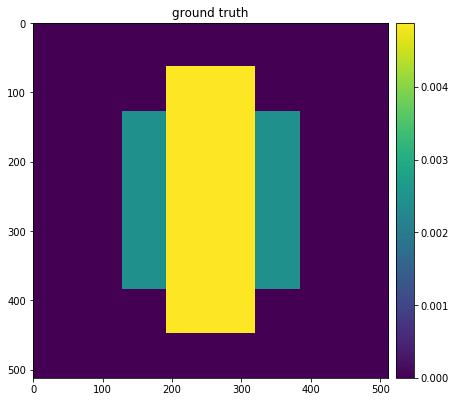

In [78]:
from ccpi.framework import TestData
import os, sys

# load test image
# initialise loader
loader = TestData(data_dir = os.path.join(sys.prefix, 'share','ccpi'))
# load data
data = loader.load(TestData.SIMPLE_PHANTOM_2D, size = (N, N))
# scale data
data *= 2.5 / N

plotter2D([data],
          ['ground truth'])

Now, we can pass actual sinogram to `AcquisitionData`:

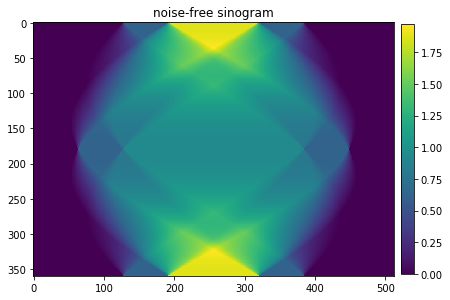

In [41]:
ad.fill(get_ideal_sino(data, N, n_angles))

plotter2D([ad],
          ['noise-free sinogram'])

### CT data preprocessing

As X-ray photons travel from an X-ray source to detector elements they interact with matter along their trajectories. In these interactions, photons are either absorbed or scattered, resulting in the attenuation of the incident X-ray. A quantitative description of the interaction of X-rays with matter is given by the Beer-Lambert law (or Beer’s law).
$$I^{l} = I^0 \mathrm{exp}\left( -\int_{l} f(g) \mathrm{d}l \right)$$
where $f(g)$ is the X-ray linear attenuation coefficient of the object at the position $g$ along a given linear X-ray trajectory $l$ from the source to the detector element. If $l$ is the entire trajectory from the source to the detector element, then $I^0$ corresponds to the X-ray intensity upon emission from the source and $I^{l}$ corresponds to the X-ray intensity upon incidence on the detector element. $I^{l}$ is typically called a transmission measurement, whereas a projection measurement is given by
$$G^{l} = -\log \left( \frac{I^{l}}{I^0} \right) = \int_{l} f(g) \mathrm{d}l$$

Ideally, $I^0$ is a single value, but real detector pixels do respond equally to photon flux. Secondly, pixels might have residual charge (so called dark current). Therefore, to convert $I^{l}$ to $G^{l}$, one needs to perform flat field correction. If $I^F$ is a flat field image (acquired with source on, without an object in the field of view) and $I^d$ is a dark field image (acquired with source off), then flat field correction is given by:
$$\frac{I-I^D}{I^F-I^D}$$

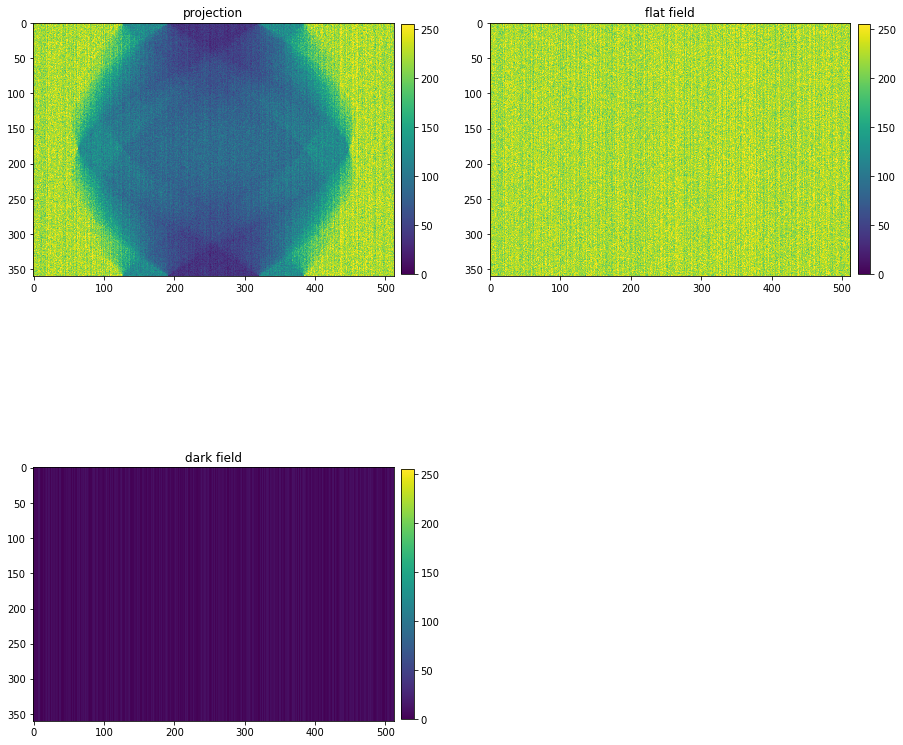

In [42]:
# simulated noisy sinogram, flat and dark field images
proj_tmp, flat_tmp, dark_tmp  = get_real_sino(data, N, n_angles, 8)

plotter2D([proj_tmp, flat_tmp, dark_tmp], 
          ['projection', 'flat field', 'dark field'], 
          fix_range = True, 
          stretch_y = False)

In [43]:
proj_noisy = ag.allocate()
proj_noisy.fill(proj_tmp)

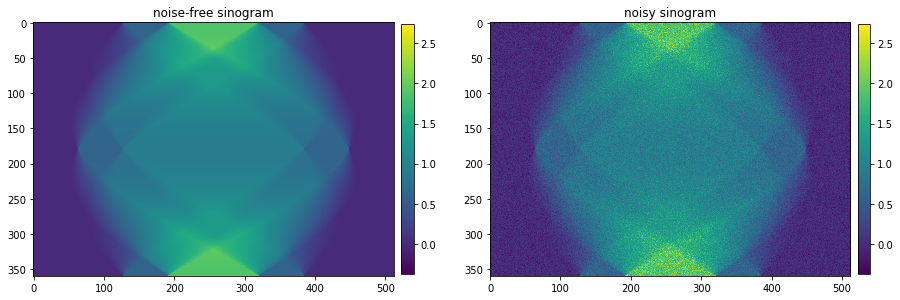

In [44]:
# wrap  flat and dark field images as AcquisitionData objects
flat = ag.allocate()
flat.fill(flat_tmp)
dark = ag.allocate()
dark.fill(dark_tmp)

# and perform flat field correction and take negative logarithm
ad_noisy = -1*(((proj_noisy - dark) / (flat - dark)).log())

plotter2D([ad, ad_noisy], 
          ['noise-free sinogram', 'noisy sinogram'], 
          fix_range = True, 
          stretch_y = False)

### CT reconstruction
Tomographic reconstruction consists of resolving the three-dimensional photon attenuation map of a scanned object from the collection of projection measurement $G^{l}$. There are two major classes of reconstruction algorithms: *analytic* and *iterative*. 

#### Analytic reconstruction
The most common analytic reconstruction algorithm is filtered back-projection (FBP). The FBP algorithm is derived from the Fourier Slice theorem which relates line integral measurements to two dimensional Fourier transform of an object’s slice. Although the Fourier Slice theorem provides straightforward solution for tomographic reconstruction, its practical implementation is challenging due to required interpolation from Polar to Cartesian coordinates in the Fourier space. In FBP-type reconstruction methods, projections are ﬁltered independently and then back-projected onto the plane of the tomographic slice. Filtration is used to compensate for nonuniform sampling of the Fourier space (higher frequencies have higher density of sampling points) by linear (Ramp) weighting of the frequency space.

In [45]:
# imports
from ccpi.astra.processors import FBP

# reconstruction settings
dev = 'cpu' # can be 'gpu'

# create ImageGeometry 
ig = ImageGeometry(voxel_num_x = ag.pixel_num_h,
                   voxel_size_x = ag.pixel_size_h,
                   voxel_num_y = ag.pixel_num_h,
                   voxel_size_y = ag.pixel_size_h)

# reconstruct noise-free data
fbp = FBP(volume_geometry = ig, 
          sinogram_geometry = ag,
          device = dev)
fbp.set_input(ad)
recon_fbp_ideal = fbp.process()

# reconstruct noisy data
fbp.set_input(ad_noisy)
recon_fbp_noisy = fbp.process()

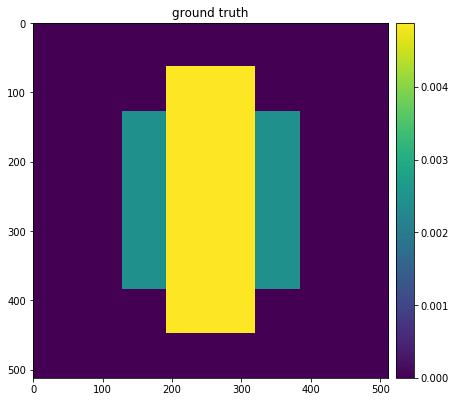

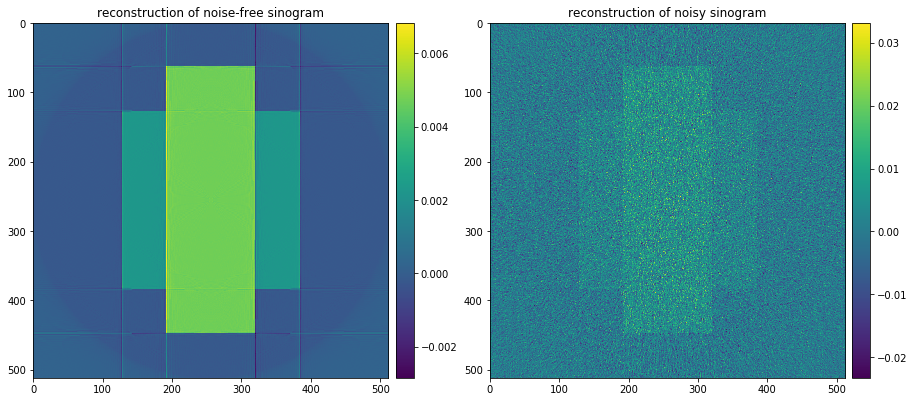

In [69]:
plotter2D([data], 
          ['ground truth'])

plotter2D([recon_fbp_ideal, recon_fbp_noisy], 
          ['reconstruction of noise-free sinogram', 'reconstruction of noisy sinogram'], 
          fix_range = False, 
          stretch_y = False)

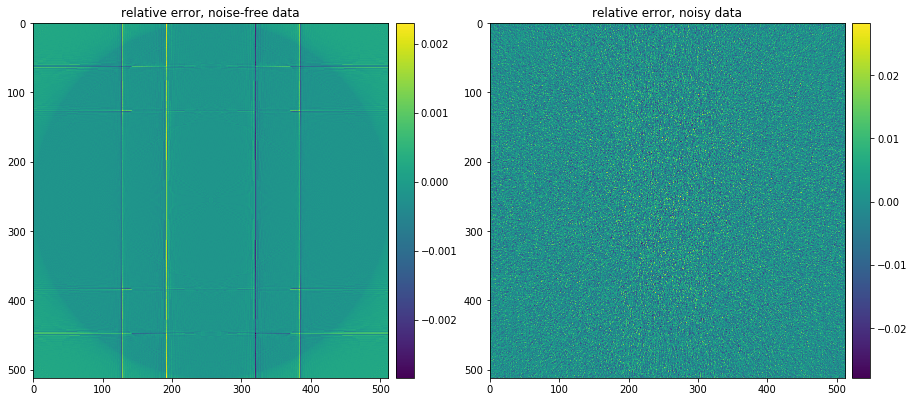

In [70]:
# show residuals
plotter2D([(recon_fbp_ideal - data), (recon_fbp_noisy - data)], 
          ['relative error, noise-free data', 'relative error, noisy data'], 
          fix_range = False, 
          stretch_y = False)

**Exercise 1**: use the following mask to simulate missing angles acquisition and perform reconstruction again for both noise-free and noisy data.

New acquisition angles are now given by the following `mask`:
```
a = np.int32((np.arange(1,20) * np.arange(0,19)) / 2)
mask = np.concatenate([a, n_angles - 1 - a[::-1]])
```
*Hint*: you do not need to generate sinograms again, you can create new `AcquisitionGeometry` and `AcquisitionData` using `numpy` slicing, for instance:
```
ad_low = ag_low.allocate()
ad_low.fill(ad.as_array()[mask,:])
```

**Answer, Exercise 1**

In [79]:
a = np.int32(np.round((np.arange(1,28) * np.arange(0,27)) / 4))
mask = np.concatenate([a, n_angles - 1 - a[::-1]])

# create new AcquisitionGeometry
ag_low = ag.clone()
ag_low.angles = angles[mask]

print(ag_low)

Number of dimensions: 2D
angles: [0.         0.         0.01750191 0.02625286 0.04375477 0.07000764
 0.08750954 0.12251336 0.15751718 0.19252099 0.24502672 0.2887815
 0.34128723 0.4025439  0.45504963 0.52505726 0.5950649  0.66507256
 0.7525821  0.8313407  0.91885024 1.0151107  1.1026202  1.2076317
 1.3126432  1.4176546  1.5401679  1.6014247  1.723938   1.8289495
 1.9339609  2.0389724  2.126482   2.2227423  2.310252   2.3890107
 2.47652    2.5465279  2.6165354  2.686543   2.7390487  2.8003054
 2.852811   2.896566   2.9490716  2.9840755  3.0190792  3.054083
 3.071585   3.097838   3.1153398  3.1240907  3.1415927  3.1415927 ]
voxel_num : h512,v0
voxel size: h1,v1
geometry type: parallel
distance source-detector: None
distance center-detector: None
number of channels: 1



In [80]:
# allocate new AcquisitionData
ad_low = ag_low.allocate()
ad_low.fill(ad.as_array()[mask,:])

ad_low_noisy = ag_low.allocate()
ad_low_noisy.fill(ad_noisy.as_array()[mask,:])

print('Dimensions and Labels = {}, {}'.format(ad_low.shape, ad_low.dimension_labels))

Dimensions and Labels = (54, 512), {0: u'angle', 1: u'horizontal'}


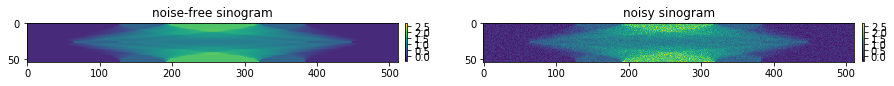

In [81]:
plotter2D([ad_low, ad_low_noisy], 
          ['noise-free sinogram', 'noisy sinogram'], 
          fix_range = True, 
          stretch_y = False)

In [82]:
# reconstruct noise-free data
fbp = FBP(volume_geometry = ig, 
          sinogram_geometry = ag_low,
          device = dev)
fbp.set_input(ad_low)
recon_fbp_low_ideal = fbp.process()

# reconstruct noisy data
fbp.set_input(ad_low_noisy)
recon_fbp_low_noisy = fbp.process()

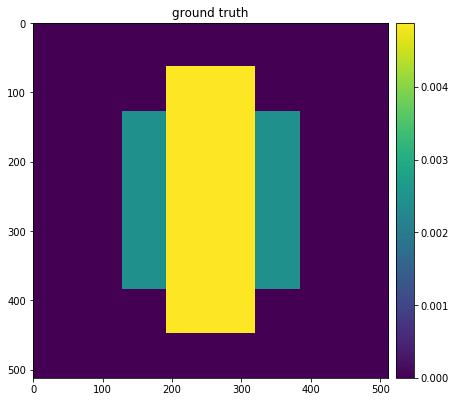

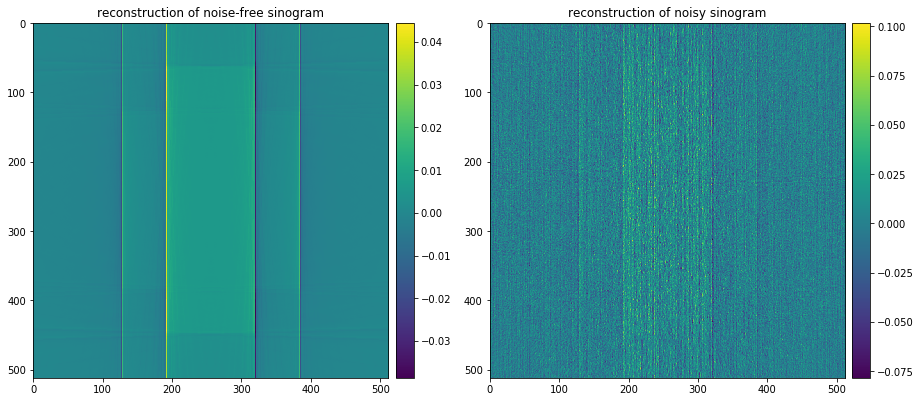

In [83]:
plotter2D([data], 
          ['ground truth'])

plotter2D([recon_fbp_low_ideal, recon_fbp_low_noisy], 
          ['reconstruction of noise-free sinogram', 'reconstruction of noisy sinogram'], 
          fix_range = False, 
          stretch_y = False)

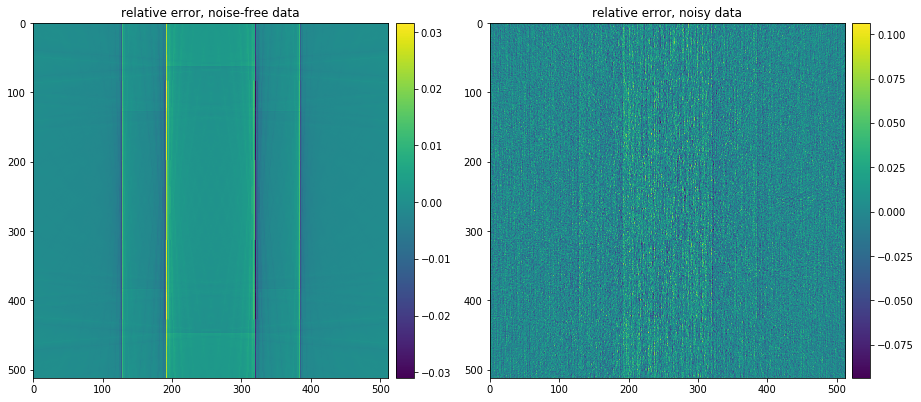

In [76]:
# show residuals
plotter2D([(recon_fbp_low_ideal - data), (recon_fbp_low_noisy - data)], 
          ['relative error, noise-free data', 'relative error, noisy data'], 
          fix_range = False, 
          stretch_y = False)

#### Iterative reconstruction
Iterative methods use an initial estimate of volume voxel values which is then iteratively updated to best reproduce acquired radiographic data. Here we discuss formulation of iterative reconstruction for 2D parallel geoemtry, extension to other geometies is straightforward. Iterative methods formulate the reconstruction methods as a system of linear equations
$$Ax = b$$
- $x$ is the volume to be reconstructed. $x$ is typically represented as a column vector with $N \cdot N \times 1$ elements, where $N$ is the number of elements in a detector row.
- $b$ is measured data from $M$ measurements (projections), $b$ is a column vector with $M \cdot N \times 1$ elements
- $A$ is the projection operator with $M \cdot N \times N \cdot N$ elements. If $i, i = \{0, 1, \dots M \cdot N - 1 \}$ and $j, j = \{0, 1, \dots, N \cdot N - 1\}$, then $A_{i,j}$ is the length of intersection of the $i$.th ray with the $j$.th voxel.

For any real application, problem size is too large to be solved by direct inversion methods, i.e.
$$x = A^{-1}b$$
Secondly, the projection matrix $A$ is often under-determined, i.e. $$M \ll N$$ (low number of projection or missing projections). Therefore we formulate reconstruction as an optimization problem and use iterative solvers to solve:

$$\underset{x}{\mathrm{argmin}}\begin{Vmatrix}A x - b\end{Vmatrix}^2_2$$

Since iterative methods involve forward- and back-projection steps, assumptions about data acquisition can be incorporated into the reconstruction procedure. However, iterative methods are computationally demanding, you will notice that it takes much longer to get reconstruction results with iterative methods.

In this notebook, we will use the simplest 


where,
- $A$ is the projection operator
- $b$ is the acquired data
- $x$ is the solution

In [88]:
# imports
from ccpi.optimisation.algorithms import CGLS

#define the operator A
device = "cpu"
operator = AstraProjectorSimple(ig, ag, device)

x_init = ig.allocate(0)

#setup CGLS
x_init = ig.allocate()
cgls = CGLS(x_init = x_init, 
            operator = operator, 
            data = ad)
cgls.max_iteration = 1000
cgls.update_objective_interval = 100

CGLS setting up
CGLS configured


### Summary